<a href="https://colab.research.google.com/github/swicklund/hackathon/blob/main/RevisedPhysicsModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import tensorflow as tf
import json
import zipfile
from io import BytesIO
import torch
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta


In [2]:
auth.authenticate_user()

In [3]:
!gcloud config set project {'hackathon-352519'}

Updated property [core/project].


In [4]:
!gsutil cp gs://trains_data/* /tmp/.

Copying gs://trains_data/train-data_all-train-events.zip...
- [1 files][ 57.1 MiB/ 57.1 MiB]                                                
Operation completed over 1 objects/57.1 MiB.                                     


In [5]:
# z = zipfile.ZipFile('train-data_all-train-events.zip', 'r')

x = {}
trains = {}
i = 1
prevLoco = ''
with zipfile.ZipFile("/tmp/train-data_all-train-events.zip", "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                # prevLoco != currentLoco and 
                if ("trainActualPositionList" in lastTrainReporting and "trainEstimatedPositionList" in lastTrainReporting and len(lastTrainReporting['trainEstimatedPositionList']) > 0): 
                    trainActualPositionList = lastTrainReporting['trainActualPositionList']
                    for position in trainActualPositionList:
                        positions = pd.json_normalize(position)
                        trains[i] = pd.json_normalize(lastTrainReporting)
#                             x[i] = pd.concat([train.ptcLeadLocomotiveId,trains[i]["trainId.trainSymbol"], trains[i]["trainId.trainDate"], positions], axis=1)
                        x[i] = positions
#                             trains[i] = train 
                        i = i + 1
                        prevLoco = currentLoco
                            

In [6]:
df = pd.concat(x.values())
dfTrainsAll = pd.concat(trains.values())

In [7]:
del x
del trains

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143050 entries, 0 to 0
Data columns (total 13 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   positionTime                                          143050 non-null  object 
 1   speedMPH                                              143050 non-null  int64  
 2   milepostLocation.subdivisionId                        143050 non-null  int64  
 3   milepostLocation.trackName                            143050 non-null  object 
 4   milepostLocation.milepost.milepostNumber              143050 non-null  float64
 5   nextSignalState.milepostLocation.milepostNumber       123498 non-null  float64
 6   nextSignalState.signalState                           123498 non-null  float64
 7   precedingSignalState.milepostLocation.milepostNumber  124689 non-null  float64
 8   precedingSignalState.previousSignalState         

In [9]:
print(dfTrainsAll.info())
print(dfTrainsAll.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143050 entries, 0 to 0
Data columns (total 44 columns):
 #   Column                                                                     Non-Null Count   Dtype  
---  ------                                                                     --------------   -----  
 0   ptcLeadLocomotiveId                                                        143050 non-null  object 
 1   maximumTrainSpeed                                                          143050 non-null  int64  
 2   loadedCarCount                                                             143050 non-null  int64  
 3   emptyCarCount                                                              143050 non-null  int64  
 4   trainLength                                                                143050 non-null  int64  
 5   trailingTonnage                                                            143050 non-null  int64  
 6   positionHistoryList                              

# Step 2: Augment Existing Physics BEoP model with standard deviations from most recent readings.

In [10]:
dfTrainsAll["milepost"] = dfTrainsAll.apply(lambda row: math.trunc(row['lastReportedPosition.milepostLocation.milepost.milepostNumber']), axis=1)
dfTrainsAll["hour"] = dfTrainsAll.apply(lambda row: (row['lastReportedPosition.positionTime']).rsplit(":")[0], axis=1)

In [11]:
dfTrainsAll.head()

,ptcLeadLocomotiveId,maximumTrainSpeed,loadedCarCount,emptyCarCount,trainLength,trailingTonnage,positionHistoryList,locomotiveList,subdivisionList,trainEstimatedPositionList,...,lastReportedPosition.nextSignalState.milepostLocation.milepostNumber,lastReportedPosition.nextSignalState.signalState,lastReportedPosition.precedingSignalState.milepostLocation.milepostNumber,lastReportedPosition.precedingSignalState.previousSignalState,lastReportedPosition.precedingSignalState.currentStateTime,lastReportedPosition.precedingSignalState.signalState,lastReportedPosition.nextSignalState.previousSignalState,lastReportedPosition.nextSignalState.currentStateTime,milepost,hour
0,UP2010,50,61,92,9282,10992,"[{'positionTime': '2022-04-21T23:31:08Z', 'spe...","[{'locomotiveId': 'UP2010', 'positionOnTrain':...","[{'subdivisionId': 595}, {'subdivisionId': 538...","[{'positionTime': '2022-04-21T23:31:08Z', 'spe...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,766,2022-04-21T23
0,UP2010,50,61,92,9282,10992,"[{'positionTime': '2022-04-21T23:31:08Z', 'spe...","[{'locomotiveId': 'UP2010', 'positionOnTrain':...","[{'subdivisionId': 595}, {'subdivisionId': 538...","[{'positionTime': '2022-04-21T23:31:08Z', 'spe...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,766,2022-04-21T23
0,UP2010,50,61,92,9282,10992,"[{'positionTime': '2022-04-21T23:31:08Z', 'spe...","[{'locomotiveId': 'UP2010', 'positionOnTrain':...","[{'subdivisionId': 595}, {'subdivisionId': 538...","[{'positionTime': '2022-04-21T23:31:08Z', 'spe...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,766,2022-04-21T23
0,UP2010,50,61,92,9282,10992,"[{'positionTime': '2022-04-21T23:31:08Z', 'spe...","[{'locomotiveId': 'UP2010', 'positionOnTrain':...","[{'subdivisionId': 595}, {'subdivisionId': 538...","[{'positionTime': '2022-04-21T23:31:08Z', 'spe...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,766,2022-04-21T23
0,UP2010,50,61,92,9282,10992,"[{'positionTime': '2022-04-21T23:31:08Z', 'spe...","[{'locomotiveId': 'UP2010', 'positionOnTrain':...","[{'subdivisionId': 595}, {'subdivisionId': 538...","[{'positionTime': '2022-04-21T23:31:08Z', 'spe...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,766,2022-04-21T23


In [12]:
dfTrains = dfTrainsAll.drop_duplicates(subset=['ptcLeadLocomotiveId', 'trainId.trainSymbol', 'trainId.trainDate', 'hour'], keep='first')
print(dfTrains.shape)
print(dfTrains.iloc[0])

(186, 46)
ptcLeadLocomotiveId                                                                                                     UP2010
maximumTrainSpeed                                                                                                           50
loadedCarCount                                                                                                              61
emptyCarCount                                                                                                               92
trainLength                                                                                                               9282
trailingTonnage                                                                                                          10992
positionHistoryList                                                          [{'positionTime': '2022-04-21T23:31:08Z', 'spe...
locomotiveList                                                               [{'locomotiveId': 'UP201

In [13]:
print(dfTrains.iloc[25]['trainId.trainSymbol'], dfTrains.iloc[25]['trainActualPositionList'])
act = pd.json_normalize(dfTrains.iloc[25]['trainActualPositionList'])
print(act['positionTime'])

MALNP [{'positionTime': '2022-04-22T05:40:20Z', 'speedMPH': 7, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 2-MT 1', 'milepost': {'milepostNumber': 202.98804}}, 'precedingSignalState': {'milepostLocation': {'milepostNumber': 202.73}, 'signalState': 1}, 'nextSignalState': {'milepostLocation': {'milepostNumber': 204.19}, 'signalState': 4}}, {'positionTime': '2022-04-22T05:42:20Z', 'speedMPH': 7, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 203.2537}}, 'precedingSignalState': {'milepostLocation': {'milepostNumber': 202.73}, 'signalState': 1}, 'nextSignalState': {'milepostLocation': {'milepostNumber': 204.19}, 'signalState': 4}}, {'positionTime': '2022-04-22T05:44:20Z', 'speedMPH': 10, 'milepostLocation': {'subdivisionId': 106, 'trackName': 'MT 1', 'milepost': {'milepostNumber': 203.58463}}, 'precedingSignalState': {'milepostLocation': {'milepostNumber': 202.73}, 'signalState': 1}, 'nextSignalState': {'milepostLocation': {'mi

In [14]:
def formatTrain(dfTrain):
  actuals = pd.json_normalize(dfTrain['trainActualPositionList'])
  cols = list(actuals.columns)
  dfx = (actuals[cols[0:2] + cols[3:5]])
  dfx = dfx.rename(columns={"speedMPH" : "speedMPH", "milepostLocation.trackName":"trackName", "milepostLocation.milepost.milepostNumber": "milepostNumber" })
  est = pd.json_normalize(dfTrain['trainEstimatedPositionList'])  
  beop = est.rename(columns={"speedMPH" : "forecastSpeedMPH", "milepostLocation.trackName":"forecastTrackName", "milepostLocation.milepost.milepostNumber": "forecastMilepostNumber" })
  joined = beop.join(dfx, lsuffix='_beop', rsuffix='_actual')
  dn = joined.dropna()
  dn = dn.loc[(dn['speedMPH'] != 0)]
  delta = abs(dn["speedMPH"] - dn["forecastSpeedMPH"]);
  #dn = dn.apply(lambda x: abs(x) if x.name=='speedMPH' or  x.name=='forecastSpeedMPH' else x)
  dn["delta"] = delta
  try:
    dn['milepost'] = dn.apply(lambda row: math.trunc(row['milepostNumber']), axis=1) 
    dn['millis'] = dn.apply(lambda row: ((datetime.strptime(row['positionTime_actual'], "%Y-%m-%dT%H:%M:%SZ"))  - datetime(1970, 1, 1)) // timedelta(milliseconds=1), axis=1)
  except ValueError:
    print (ValueError)
    print("Oops!  invalid format", dn)
  dn['trainId'] = dfTrain['trainId.trainSymbol']+" "+dfTrain['trainId.trainDate']
  dn = dn.drop(columns=['milepostLocation.subdivisionId'])
  # dn = dn.reset_index()
  return dn

In [15]:
trainsList = []
for index, train in dfTrains.iterrows():
  # print(train['trainId.trainSymbol'])
  trainsList.append(formatTrain(train))
trains = pd.concat(trainsList)
trains = trains.sort_values(['trainId','positionTime_actual'])
trains = trains.drop_duplicates(subset=['trainId', 'milepost'], keep='last')
trains = trains.reset_index()

<class 'ValueError'>
Oops!  invalid format Empty DataFrame
Columns: [positionTime_beop, forecastSpeedMPH, milepostLocation.subdivisionId, forecastTrackName, forecastMilepostNumber, positionTime_actual, speedMPH, trackName, milepostNumber, delta]
Index: []


In [16]:
trains.loc[trains['trainId'].str.startswith('MALNP')]

,index,positionTime_beop,forecastSpeedMPH,forecastTrackName,forecastMilepostNumber,positionTime_actual,speedMPH,trackName,milepostNumber,delta,milepost,millis,trainId
842,15,2022-04-22T06:08:20Z,50,YD LD,224.92500,2022-04-22T06:12:20Z,1.0,MT 2,202.92322,49.0,202.0,1.650608e+12,MALNP 2022-04-18
843,18,2022-04-22T06:14:20Z,50,YD LD,229.92480,2022-04-22T06:18:20Z,17.0,MT 1,203.84268,33.0,203.0,1.650608e+12,MALNP 2022-04-18
844,3,2022-04-22T06:19:22Z,48,MT 2,206.10748,2022-04-22T06:21:22Z,27.0,MT 1,204.78294,21.0,204.0,1.650608e+12,MALNP 2022-04-18
845,4,2022-04-22T06:21:22Z,50,MT 2,207.77267,2022-04-22T06:23:22Z,37.0,MT 1,205.78806,13.0,205.0,1.650609e+12,MALNP 2022-04-18
846,21,2022-04-22T06:20:20Z,50,YD LD,234.92460,2022-04-22T06:24:20Z,39.0,MT 1,206.42480,11.0,206.0,1.650609e+12,MALNP 2022-04-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067,30,2022-04-25T19:00:00Z,50,MT 2,323.94800,2022-04-25T19:02:00Z,36.0,MT 2,321.06220,14.0,321.0,1.650913e+12,MALNP 2022-04-22
1068,31,2022-04-25T19:02:00Z,50,MT 2,325.61792,2022-04-25T19:04:00Z,36.0,MT 2,322.24470,14.0,322.0,1.650913e+12,MALNP 2022-04-22
1069,32,2022-04-25T19:04:00Z,50,MT 2,327.28784,2022-04-25T19:06:00Z,35.0,MT 2,323.43582,15.0,323.0,1.650914e+12,MALNP 2022-04-22
1070,33,2022-04-25T19:06:00Z,50,MT 2,328.95444,2022-04-25T19:08:00Z,36.0,MT 2,324.63382,14.0,324.0,1.650914e+12,MALNP 2022-04-22


Compute the Change of Velocity entering each milepost segment

In [17]:

trains['speedChange'] = trains["speedMPH"]
prevTrain = ''
for i in range(0, len(trains)):
  if trains.loc[i, "trainId"] == prevTrain :
    trains.loc[i, "speedChange"] = trains.loc[i, "speedMPH"] - trains.loc[i-1, "speedMPH"]
  else :  
    trains.loc[i, "speedChange"] = 0.0
  prevTrain = trains.loc[i, "trainId"]
trains

,index,positionTime_beop,forecastSpeedMPH,forecastTrackName,forecastMilepostNumber,positionTime_actual,speedMPH,trackName,milepostNumber,delta,milepost,millis,trainId,speedChange
0,0,2022-04-24T13:13:18Z,-33,MT 2,326.08160,2022-04-24T13:15:18Z,-35.0,MT 2,324.91345,2.0,324.0,1.650806e+12,CBTWK9 2022-04-22,0.0
1,1,2022-04-24T13:15:18Z,-35,MT 2,324.71950,2022-04-24T13:17:18Z,-37.0,MT 2,323.67706,2.0,323.0,1.650806e+12,CBTWK9 2022-04-22,-2.0
2,2,2022-04-24T13:17:18Z,-37,MT 2,323.50348,2022-04-24T13:19:18Z,-38.0,MT 2,322.40244,1.0,322.0,1.650806e+12,CBTWK9 2022-04-22,-1.0
3,3,2022-04-24T13:19:18Z,-39,MT 2,322.21530,2022-04-24T13:21:18Z,-38.0,MT 2,321.12720,1.0,321.0,1.650806e+12,CBTWK9 2022-04-22,0.0
4,4,2022-04-24T13:21:18Z,-41,MT 2,320.86100,2022-04-24T13:23:18Z,-38.0,MT 2,319.86090,3.0,319.0,1.650807e+12,CBTWK9 2022-04-22,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3183,6,2022-04-23T23:13:59Z,-70,MT 2,205.00730,2022-04-23T23:15:59Z,-55.0,MT 2,207.40114,15.0,207.0,1.650756e+12,ZSCG2 2022-04-22,-8.0
3184,7,2022-04-23T23:15:59Z,-70,MT 2,202.67216,2022-04-23T23:17:59Z,-45.0,MT 2,205.66325,25.0,205.0,1.650756e+12,ZSCG2 2022-04-22,10.0
3185,8,2022-04-23T23:17:59Z,-70,MT 2,200.27682,2022-04-23T23:19:59Z,-30.0,MT 2,204.74213,40.0,204.0,1.650756e+12,ZSCG2 2022-04-22,15.0
3186,9,2022-04-23T23:19:59Z,-70,MT 2,197.94353,2022-04-23T23:21:59Z,-29.0,MT 2,203.73296,41.0,203.0,1.650756e+12,ZSCG2 2022-04-22,1.0


In [18]:
mps = trains['milepost'].unique()
mps.sort()
mps

array([202., 203., 204., 205., 206., 207., 208., 209., 210., 211., 212.,
       213., 214., 215., 216., 217., 218., 219., 220., 221., 222., 223.,
       224., 225., 226., 227., 228., 229., 230., 231., 232., 233., 234.,
       235., 236., 237., 238., 239., 240., 241., 242., 243., 244., 245.,
       246., 247., 248., 249., 250., 251., 252., 253., 254., 255., 256.,
       257., 258., 259., 260., 261., 262., 263., 264., 265., 266., 267.,
       268., 269., 270., 271., 272., 273., 274., 275., 276., 277., 278.,
       279., 280., 281., 282., 283., 284., 285., 286., 287., 288., 289.,
       290., 291., 292., 293., 294., 295., 296., 297., 298., 299., 300.,
       301., 302., 303., 304., 305., 306., 307., 308., 309., 310., 311.,
       312., 313., 314., 315., 316., 317., 318., 319., 320., 321., 322.,
       323., 324., 325., 326., 720., 721., 722., 723., 724., 725., 726.,
       727., 728., 729., 730., 731., 732., 733., 734., 735., 736., 737.,
       738., 739., 740., 741., 742., 743., 744., 74

In [19]:
print(trains.iloc[0])

index                                        0
positionTime_beop         2022-04-24T13:13:18Z
forecastSpeedMPH                           -33
forecastTrackName                         MT 2
forecastMilepostNumber                326.0816
positionTime_actual       2022-04-24T13:15:18Z
speedMPH                                 -35.0
trackName                                 MT 2
milepostNumber                       324.91345
delta                                      2.0
milepost                                 324.0
millis                         1650806118000.0
trainId                      CBTWK9 2022-04-22
speedChange                                0.0
Name: 0, dtype: object


In [20]:

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.width', 1000,
                       'display.precision', 3,
                       ):
  vals = trains.loc[trains['trainId'] == 'ITAG3 2022-04-20']
  #vals= vals.sort_values('positionTime_actual')
  print(vals[['index', 'positionTime_actual', 'milepost', 'milepostNumber','forecastSpeedMPH', 'speedMPH', 'speedChange']])

     index   positionTime_actual  milepost  milepostNumber  forecastSpeedMPH  speedMPH  speedChange
751      0  2022-04-24T12:40:29Z     324.0         324.968               -33     -36.0          0.0
752      1  2022-04-24T12:44:29Z     322.0         322.452               -37     -37.0         -1.0
753      2  2022-04-24T12:46:29Z     321.0         321.213               -41     -37.0          0.0
754      3  2022-04-24T12:48:29Z     319.0         319.993               -45     -36.0          1.0
755      4  2022-04-24T12:50:29Z     318.0         318.716               -48     -38.0         -2.0
756      5  2022-04-24T12:52:29Z     317.0         317.363               -51     -40.0         -2.0
757      6  2022-04-24T12:54:29Z     315.0         315.959               -54     -42.0         -2.0
758      7  2022-04-24T12:56:29Z     314.0         314.519               -56     -43.0         -1.0
759      8  2022-04-24T12:58:29Z     313.0         313.021               -58     -45.0         -2.0


In [21]:
dfTrains.iloc[3]["trainEstimatedPositionList"]                                                   

[{'milepostLocation': {'milepost': {'milepostNumber': 284.1967},
   'subdivisionId': 106,
   'trackName': 'MT 2'},
  'positionTime': '2022-04-21T23:01:13Z',
  'speedMPH': -39},
 {'milepostLocation': {'milepost': {'milepostNumber': 282.85425},
   'subdivisionId': 106,
   'trackName': 'MT 2'},
  'positionTime': '2022-04-21T23:03:13Z',
  'speedMPH': -42},
 {'milepostLocation': {'milepost': {'milepostNumber': 281.3805},
   'subdivisionId': 106,
   'trackName': 'MT 2'},
  'positionTime': '2022-04-21T23:05:13Z',
  'speedMPH': -46},
 {'milepostLocation': {'milepost': {'milepostNumber': 279.78912},
   'subdivisionId': 106,
   'trackName': 'MT 2'},
  'positionTime': '2022-04-21T23:07:13Z',
  'speedMPH': -49},
 {'milepostLocation': {'milepost': {'milepostNumber': 278.0921},
   'subdivisionId': 106,
   'trackName': 'MT 2'},
  'positionTime': '2022-04-21T23:09:13Z',
  'speedMPH': -52},
 {'milepostLocation': {'milepost': {'milepostNumber': 276.28278},
   'subdivisionId': 106,
   'trackName': 'MT 2'

In [22]:
dfTrains.iloc[3]

ptcLeadLocomotiveId                                                                                                     UP2547
maximumTrainSpeed                                                                                                           70
loadedCarCount                                                                                                             221
emptyCarCount                                                                                                                0
trainLength                                                                                                              13539
trailingTonnage                                                                                                          11805
positionHistoryList                                                          [{'positionTime': '2022-04-21T23:01:13Z', 'spe...
locomotiveList                                                               [{'locomotiveId': 'UP2547', 'posit

In [23]:
def plotTrain(trainData, trainId):
  ax = plt.gca()
  trainDF = trainData.loc[trainData['trainId'] == trainId]
  trainDF = trainDF.reset_index();
  trainsDF = trainDF.sort_values('positionTime_actual')
  trainDF = trainDF.apply(lambda x: abs(x) if x.name=='speedMPH' or  x.name=='forecastSpeedMPH' else x)  
  trainDF.plot(x = 'milepostNumber', y="speedMPH", use_index=True, kind="scatter", ax=ax, figsize=[24,10])
  trainDF.plot(x = 'milepostNumber', y="forecastSpeedMPH", use_index=True, kind="scatter", color="red", ax=ax, figsize=[24,10])
  trainDF.plot(x = 'milepostNumber', y="delta", use_index=True, kind="line", color="green", ax=ax, figsize=[24,10])
  # plt.gcf().autofmt_xdate()
  (t,b)= ax.get_xlim()  ## Added for clarity
  if t < b:
    ax.set_xlim((b,t))
  plt.title(trainId)
  plt.show()

In [24]:
trainIdsList = trains['trainId'].unique()
print(trainIdsList.size)
print(trainIdsList)

47
['CBTWK9 2022-04-22' 'CBVNR9 2022-04-21' 'CPWNR9 2022-04-21'
 'CWTOK 2022-04-30' 'EKFBTM 2022-04-29' 'IG4SE 2022-04-21'
 'ILBG3 2022-04-16' 'ITAG3 2022-04-16' 'ITAG3 2022-04-20'
 'MALNP 2022-04-18' 'MALNP 2022-04-22' 'MBTLK 2022-05-02'
 'MCBDM 2022-04-20' 'MCBDM 2022-04-21' 'MCHCB 2022-04-22'
 'MCHCB 2022-04-25' 'MCHCB 2022-05-01' 'MCHNP 2022-05-04'
 'MEWLI 2022-04-21' 'MHOLI 2022-04-20' 'MHOLI 2022-04-23'
 'MLDLI 2022-04-29' 'MLIBT 2022-04-30' 'MLIBT 2022-05-01'
 'MLIBT 2022-05-04' 'MLIHO 2022-04-21' 'MLIHO 2022-04-23'
 'MLKBT 2022-04-23' 'MNOEW 2022-04-22' 'MNOEW 2022-04-29'
 'MNOEWB 2022-04-26' 'MNOEWB 2022-05-01' 'MNOEWB 2022-05-03'
 'MNPAL 2022-04-23' 'MNPCH 2022-04-21' 'MNPSSB 2022-04-19'
 'MPRNP 2022-04-21' 'MPRNP 2022-04-25' 'MSALI 2022-04-20'
 'MSALI 2022-04-22' 'UEUMTG 2022-04-11' 'WNLDYB 2022-04-15'
 'ZBRG2B 2022-04-22' 'ZG2SC 2022-05-03' 'ZLTG2 2022-04-21'
 'ZLTG2 2022-05-01' 'ZSCG2 2022-04-22']


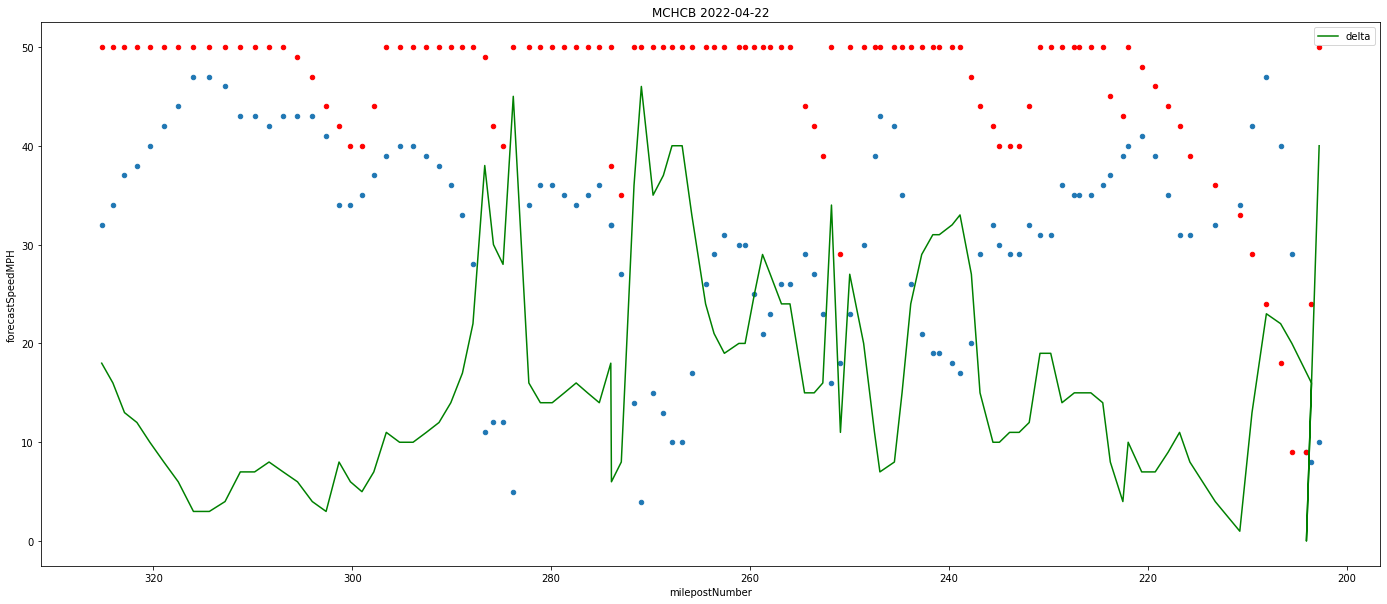

In [25]:
plotTrain(trains, trainIdsList[14])

In [26]:
trains.head()

,index,positionTime_beop,forecastSpeedMPH,forecastTrackName,forecastMilepostNumber,positionTime_actual,speedMPH,trackName,milepostNumber,delta,milepost,millis,trainId,speedChange
0,0,2022-04-24T13:13:18Z,-33,MT 2,326.08160,2022-04-24T13:15:18Z,-35.0,MT 2,324.91345,2.0,324.0,1.650806e+12,CBTWK9 2022-04-22,0.0
1,1,2022-04-24T13:15:18Z,-35,MT 2,324.71950,2022-04-24T13:17:18Z,-37.0,MT 2,323.67706,2.0,323.0,1.650806e+12,CBTWK9 2022-04-22,-2.0
2,2,2022-04-24T13:17:18Z,-37,MT 2,323.50348,2022-04-24T13:19:18Z,-38.0,MT 2,322.40244,1.0,322.0,1.650806e+12,CBTWK9 2022-04-22,-1.0
3,3,2022-04-24T13:19:18Z,-39,MT 2,322.21530,2022-04-24T13:21:18Z,-38.0,MT 2,321.12720,1.0,321.0,1.650806e+12,CBTWK9 2022-04-22,0.0
4,4,2022-04-24T13:21:18Z,-41,MT 2,320.86100,2022-04-24T13:23:18Z,-38.0,MT 2,319.86090,3.0,319.0,1.650807e+12,CBTWK9 2022-04-22,0.0


Text(0.5, 1.0, 'Mean Error')

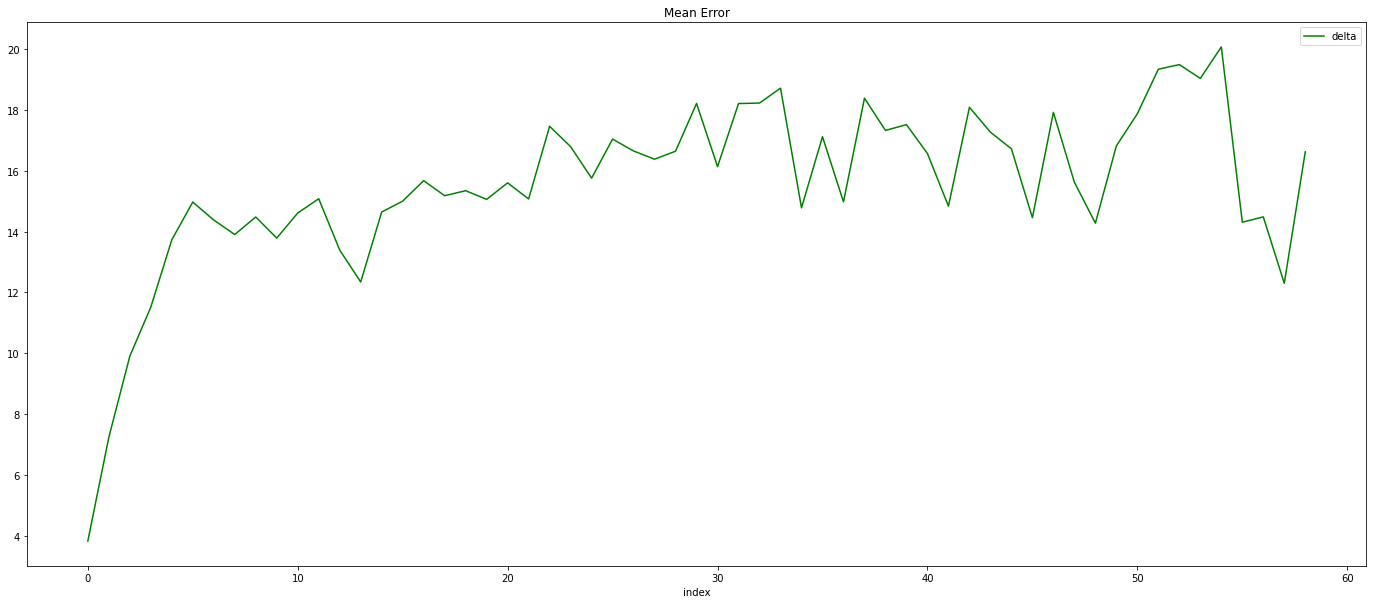

In [27]:
indexedMean = (trains[["index","delta"]]).groupby('index').mean()
indexedMean.plot( y="delta", kind="line", color="green", figsize=[24,10])
plt.title("Mean Error")

In [28]:
meanSquaredError = math.sqrt((indexedMean['delta']**2).sum())
print("Mean Squared Error: ", meanSquaredError)

Mean Squared Error:  121.25306265730632


     milepost      delta
0       202.0  33.222222
1       203.0  22.727273
2       204.0  20.380952
3       205.0  15.333333
4       206.0  13.809524
..        ...        ...
167     762.0  36.300000
168     763.0  25.900000
169     764.0  28.600000
170     765.0  29.400000
171     766.0  31.650000

[172 rows x 2 columns]


Text(0.5, 1.0, 'Mean Error by Milepost')

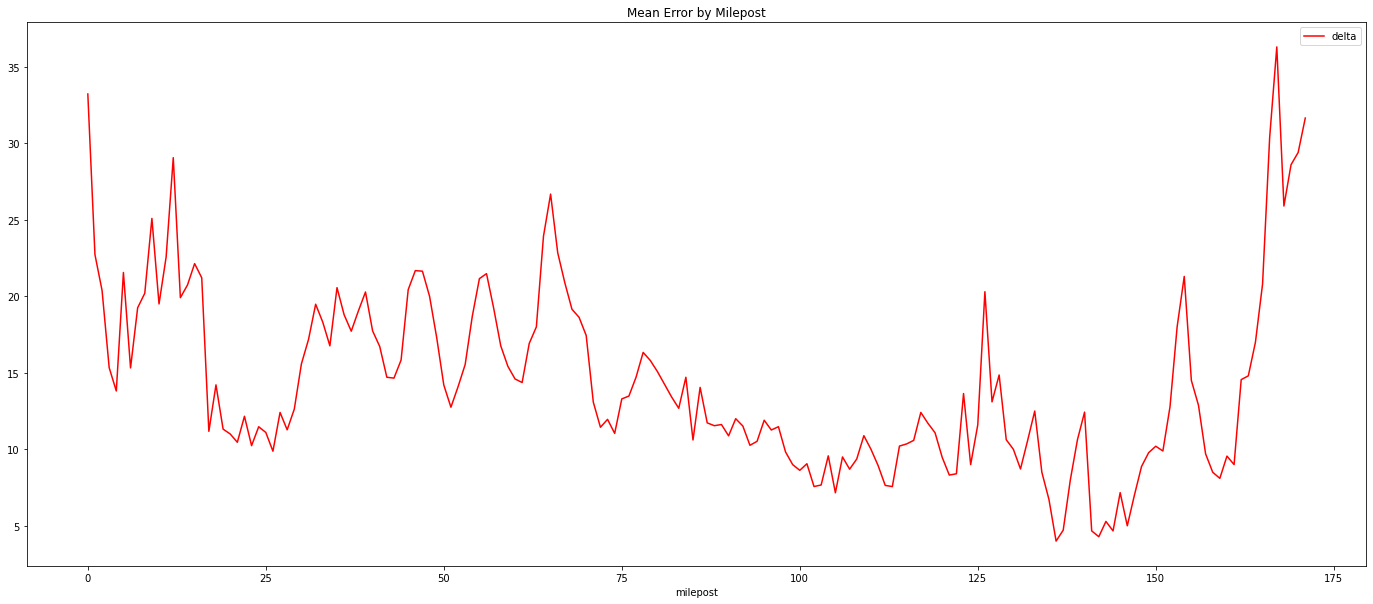

In [29]:
indexedMeanByMilepost = (trains[["milepost","delta"]]).groupby('milepost').mean()
indexedMeanByMilepost = indexedMeanByMilepost.dropna().reset_index()
print(indexedMeanByMilepost)
indexedMeanByMilepost.plot(y="delta", use_index=True, kind="line", color="red", figsize=[24,10])
# labels= indexedMeanByMilepost['milepost'].values
plt.xlabel('milepost')
plt.title("Mean Error by Milepost")

Begin Training New Model<br>
We shall govern *increase in speed* to be a maximimum of the standard deviation for the milepost area. 


In [30]:
dfTrainIds = dfTrains[['trainId.trainSymbol','trainId.trainDate','lastReportedPosition.positionTime']]
dfTrainIds = dfTrainIds.drop_duplicates(subset=['trainId.trainSymbol','trainId.trainDate'], keep='first')
dfTrainIds = dfTrainIds.sort_values(['lastReportedPosition.positionTime'])
dfTrainIds

,trainId.trainSymbol,trainId.trainDate,lastReportedPosition.positionTime
0,MNPSSB,2022-04-19,2022-04-20T20:15:40Z
0,ITAG3,2022-04-16,2022-04-21T02:54:18Z
0,MHOLI,2022-04-20,2022-04-21T07:31:25Z
0,MCBDM,2022-04-20,2022-04-21T12:09:05Z
0,ILBG3,2022-04-16,2022-04-21T21:55:32Z
0,MEWLI,2022-04-21,2022-04-21T23:31:08Z
0,CPWNR9,2022-04-21,2022-04-22T01:13:51Z
0,MALNP,2022-04-18,2022-04-22T02:25:20Z
0,CBVNR9,2022-04-21,2022-04-22T04:19:06Z
0,WNLDYB,2022-04-15,2022-04-22T04:31:06Z


In [31]:
count = dfTrainIds.shape[0]
trainingCount = count // 4 * 3
trainingSet = dfTrains.head(trainingCount)
testingSet = dfTrains.tail(count - trainingCount)

In [39]:
trainSpeeds = trains.sort_values(['trainId', 'positionTime_actual'])
trainSpeeds = trainSpeeds.drop_duplicates(subset=['trainId'], keep='first')
trainSpeeds = trainSpeeds.sort_values(['positionTime_actual'])
trainingSpeedsCount = trainSpeeds.shape[0] // 4 * 3
trainingSpeedsIdSet = trainSpeeds.head(trainingSpeedsCount)
testingSpeedsIdSet = trainSpeeds.tail(trainSpeeds.shape[0] - trainingSpeedsCount)
trainingSpeeds = pd.merge(trains, trainingSpeedsIdSet["trainId"])
trainingSpeeds

,index,positionTime_beop,forecastSpeedMPH,forecastTrackName,forecastMilepostNumber,positionTime_actual,speedMPH,trackName,milepostNumber,delta,milepost,millis,trainId,speedChange
0,0,2022-04-24T13:13:18Z,-33,MT 2,326.08160,2022-04-24T13:15:18Z,-35.0,MT 2,324.91345,2.0,324.0,1.650806e+12,CBTWK9 2022-04-22,0.0
1,1,2022-04-24T13:15:18Z,-35,MT 2,324.71950,2022-04-24T13:17:18Z,-37.0,MT 2,323.67706,2.0,323.0,1.650806e+12,CBTWK9 2022-04-22,-2.0
2,2,2022-04-24T13:17:18Z,-37,MT 2,323.50348,2022-04-24T13:19:18Z,-38.0,MT 2,322.40244,1.0,322.0,1.650806e+12,CBTWK9 2022-04-22,-1.0
3,3,2022-04-24T13:19:18Z,-39,MT 2,322.21530,2022-04-24T13:21:18Z,-38.0,MT 2,321.12720,1.0,321.0,1.650806e+12,CBTWK9 2022-04-22,0.0
4,4,2022-04-24T13:21:18Z,-41,MT 2,320.86100,2022-04-24T13:23:18Z,-38.0,MT 2,319.86090,3.0,319.0,1.650807e+12,CBTWK9 2022-04-22,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458,6,2022-04-23T23:13:59Z,-70,MT 2,205.00730,2022-04-23T23:15:59Z,-55.0,MT 2,207.40114,15.0,207.0,1.650756e+12,ZSCG2 2022-04-22,-8.0
2459,7,2022-04-23T23:15:59Z,-70,MT 2,202.67216,2022-04-23T23:17:59Z,-45.0,MT 2,205.66325,25.0,205.0,1.650756e+12,ZSCG2 2022-04-22,10.0
2460,8,2022-04-23T23:17:59Z,-70,MT 2,200.27682,2022-04-23T23:19:59Z,-30.0,MT 2,204.74213,40.0,204.0,1.650756e+12,ZSCG2 2022-04-22,15.0
2461,9,2022-04-23T23:19:59Z,-70,MT 2,197.94353,2022-04-23T23:21:59Z,-29.0,MT 2,203.73296,41.0,203.0,1.650756e+12,ZSCG2 2022-04-22,1.0


In [33]:
def minMaxMean(trainsSet): 
  vals = trainsSet
  speedChangeMean = {"speedChangeMean": trainsSet[["speedChange"]].mean()}
  speedChangeMax = {"speedChangeMax" : trainsSet[["speedChange"]].max()}
  speedChangeMin = {"speedChangeMin" : trainsSet[["speedChange"]].min()}
  speedChangeStd = {"speedChangeStd" : trainsSet[["speedChange"]].std()}
  return [speedChangeMean, speedChangeMax, speedChangeMin, speedChangeStd, vals]


In [ ]:
mps = trains['milepost'].unique()
mps.sort()
mps

In [41]:
mpSpeedsPositive = {}
for mp in mps:
  mpTrains = trainingSpeeds.loc[trainingSpeeds['milepost'].between(mp - 1, mp +1)]
  mpSpeedsPositive[mp] = minMaxMean(mpTrains.loc[mpTrains.speedMPH > 0])
mpSpeedsPositive[203.0]


[{'speedChangeMean': speedChange    3.625
  dtype: float64}, {'speedChangeMax': speedChange    16.0
  dtype: float64}, {'speedChangeMin': speedChange    0.0
  dtype: float64}, {'speedChangeStd': speedChange    5.264662
  dtype: float64},       index     positionTime_beop  forecastSpeedMPH forecastTrackName  \
 108       0  2022-04-22T04:19:06Z                37              MT 1   
 109       1  2022-04-22T04:21:06Z                50              MT 1   
 212       0  2022-04-22T01:13:51Z                47              MT 1   
 305       0  2022-04-23T09:57:45Z                31              MT 1   
 306       1  2022-04-23T09:59:45Z                38              MT 1   
 730      15  2022-04-22T06:08:20Z                50             YD LD   
 731      18  2022-04-22T06:14:20Z                50             YD LD   
 732       3  2022-04-22T06:19:22Z                48              MT 2   
 844       8  2022-04-25T12:42:03Z                50             YD LD   
 845      19  2022-04-2

In [42]:
mpSpeedsNegative = {}
for mp in mps:
  mpTrains = trainingSpeeds.loc[trainingSpeeds['milepost'].between(mp - 1, mp +1)]
  mpSpeedsNegative[mp] = minMaxMean(mpTrains.loc[mpTrains.speedMPH < 0])
mpSpeedsNegative[203.0]


[{'speedChangeMean': speedChange    3.538462
  dtype: float64}, {'speedChangeMax': speedChange    19.0
  dtype: float64}, {'speedChangeMin': speedChange   -19.0
  dtype: float64}, {'speedChangeStd': speedChange    8.367703
  dtype: float64},       index     positionTime_beop  forecastSpeedMPH forecastTrackName  \
 106      55  2022-04-24T17:53:49Z               -50              MT 2   
 107      56  2022-04-24T17:55:49Z               -50              MT 2   
 533      44  2022-04-22T01:28:47Z               -70              MT 1   
 534      14  2022-04-22T01:30:02Z               -70              MT 2   
 637      19  2022-04-21T05:38:46Z               -70              MT 2   
 638      20  2022-04-21T05:40:46Z               -70              MT 2   
 1068      5  2022-04-21T22:39:37Z               -37              MT 1   
 1069      6  2022-04-21T22:41:37Z               -40              MT 1   
 1181      3  2022-04-23T01:32:14Z               -29              MT 2   
 1182      6  2022-